In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import seaborn as sns

from numpy.typing import NDArray
from pydantic import BaseModel, Field, model_validator, field_validator
from tqdm.notebook import tqdm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "multilevel_elasticities_single_sku"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
class Sku(BaseModel):
    id: int = Field(..., ge=0)
    prices: NDArray[np.float_]
    sales: NDArray[np.float_]

    class Config:
        arbitrary_types_allowed = True

    @field_validator("prices", "sales")
    def validate_gt_0(cls, value):
        if (value <= 0).any():
            raise ValueError("prices and sales must be positive")
        return value

    @field_validator("prices", "sales")
    def validate_size_gt_0(cls, value):
        if value.size == 0:
            raise ValueError("prices and sales must have at least one element")
        return value

    @model_validator(mode="before")
    def validate_sizes(cls, values):
        if values["prices"].size != values["sales"].size:
            raise ValueError("prices and sales must have the same size")
        return values

    def to_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(
            data={
                "item_id": self.id,
                "price": self.prices,
                "sales": self.sales,
                "time_step": np.arange(self.prices.size)[::-1],
            }
        )


class Store(BaseModel):
    id: int = Field(..., ge=0)
    items: list[Sku] = Field(..., min_items=1)

    @field_validator("items")
    def validate_item_ids(cls, value):
        if len({item.id for item in value}) != len(value):
            raise ValueError("items must have unique ids")
        return value

    def to_dataframe(self) -> pd.DataFrame:
        df = pd.concat([item.to_dataframe() for item in self.items], axis=0)
        df["store_id"] = self.id
        df["region_store_id"] = f"r-{self.id}_s-" + df["store_id"].astype(str)
        return df.reset_index(drop=True)


class Region(BaseModel):
    id: int = Field(..., ge=0)
    stores: list[Store] = Field(..., min_items=1)
    median_income: float = Field(..., gt=0)  # Z_j

    @field_validator("stores")
    def validate_store_ids(cls, value):
        if len({store.id for store in value}) != len(value):
            raise ValueError("stores must have unique ids")
        return value

    def to_dataframe(self) -> pd.DataFrame:
        df = pd.concat([store.to_dataframe() for store in self.stores], axis=0)
        df["region_id"] = self.id
        df["median_income"] = self.median_income
        return df.reset_index(drop=True)


class Market(BaseModel):
    regions: list[Region] = Field(..., min_items=1)

    @field_validator("regions")
    def validate_region_ids(cls, value):
        if len({region.id for region in value}) != len(value):
            raise ValueError("regions must have unique ids")
        return value

    def to_dataframe(self) -> pd.DataFrame:
        df = pd.concat([region.to_dataframe() for region in self.regions], axis=0)
        return df.reset_index(drop=True)

In [4]:
class LinearRegressionConfig(BaseModel):
    intercept: float
    slope: float
    sigma: float = Field(..., gt=0)


class MultiLevelElasticitiesDataGenerator(BaseModel):
    rng: np.random.Generator
    n_regions: int = Field(..., gt=0)
    time_range_mu: float = Field(..., gt=0)
    time_range_sigma: float = Field(..., gt=0)
    n_stores_per_region_mu: float = Field(..., gt=0)
    n_stores_per_region_sigma: float = Field(..., gt=0)
    median_income_per_region_mu: float = Field(..., gt=0)
    median_income_per_region_sigma: float = Field(..., gt=0)
    intercepts_lr_config: LinearRegressionConfig
    slopes_lr_config: LinearRegressionConfig
    price_mu: float = Field(..., gt=0)
    price_sigma: float = Field(..., gt=0)
    epsilon: float = Field(..., gt=0)

    class Config:
        arbitrary_types_allowed = True

    def get_n_stores_per_region_draws(self) -> NDArray:
        n_stores_per_region_dist = pm.NegativeBinomial.dist(
            mu=self.n_stores_per_region_mu, alpha=self.n_stores_per_region_sigma
        )
        n_stores_per_region_draws = pm.draw(
            n_stores_per_region_dist, draws=self.n_regions, random_seed=self.rng
        )
        return n_stores_per_region_draws + 2

    def get_median_income_per_region_draws(self) -> NDArray:
        median_income_per_region_dist = pm.Gamma.dist(
            mu=self.median_income_per_region_mu,
            sigma=self.median_income_per_region_sigma,
        )
        median_income_per_region_draws = pm.draw(
            median_income_per_region_dist, draws=self.n_regions, random_seed=self.rng
        )
        return median_income_per_region_draws + 1

    def get_store_time_range(self) -> int:
        time_range_dist = pm.NegativeBinomial.dist(
            mu=self.time_range_mu, alpha=self.time_range_sigma
        )
        time_range_samples = pm.draw(
            vars=time_range_dist, draws=1, random_seed=self.rng
        ).item()
        return time_range_samples + 2

    def get_alpha_j_samples(
        self, median_income_per_region: float, store_time_range: int
    ) -> NDArray:
        alpha_j_dist = pm.Normal.dist(
            mu=self.intercepts_lr_config.intercept
            + self.intercepts_lr_config.slope * median_income_per_region,
            sigma=self.intercepts_lr_config.sigma,
        )
        return pm.draw(alpha_j_dist, draws=store_time_range, random_seed=self.rng)

    def get_beta_j_samples(
        self, median_income_per_region: float, store_time_range: int
    ) -> NDArray:
        beta_j_dist = pm.Normal.dist(
            mu=self.slopes_lr_config.intercept
            + self.slopes_lr_config.slope * median_income_per_region,
            sigma=self.slopes_lr_config.sigma,
        )
        return pm.draw(beta_j_dist, draws=store_time_range, random_seed=self.rng)

    def get_prices_samples(self, store_time_range: int) -> NDArray:
        price_dist = pm.Gamma.dist(
            mu=self.price_mu,
            sigma=self.price_sigma,
        )
        return pm.draw(price_dist, draws=store_time_range, random_seed=self.rng)

    def get_sales_samples(
        self, alpha_j_samples, beta_j_samples, prices_samples
    ) -> NDArray:
        log_sales_dist = pm.Normal.dist(
            mu=alpha_j_samples + beta_j_samples * np.log(prices_samples),
            sigma=self.epsilon,
        )
        log_sales_samples = pm.draw(log_sales_dist, draws=1, random_seed=self.rng)
        return np.exp(log_sales_samples)

    def create_store(self, id: int, median_income_per_region: float) -> Store:
        store_time_range = self.get_store_time_range()
        alpha_j_samples = self.get_alpha_j_samples(
            median_income_per_region=median_income_per_region,
            store_time_range=store_time_range,
        )
        beta_j_samples = self.get_beta_j_samples(
            median_income_per_region=median_income_per_region,
            store_time_range=store_time_range,
        )
        prices_samples = self.get_prices_samples(store_time_range=store_time_range)
        sales_samples = self.get_sales_samples(
            alpha_j_samples=alpha_j_samples,
            beta_j_samples=beta_j_samples,
            prices_samples=prices_samples,
        )
        return Store(
            id=id, items=[Sku(id=0, prices=prices_samples, sales=sales_samples)]
        )

    def create_region(
        self, id: int, n_stores_per_region: int, median_income_per_region: float
    ) -> Region:
        stores: list[Store] = [
            self.create_store(id=i, median_income_per_region=median_income_per_region)
            for i in range(n_stores_per_region)
        ]
        return Region(id=id, stores=stores, median_income=median_income_per_region)

    def run(self) -> Market:
        n_stores_per_region_draws = self.get_n_stores_per_region_draws()
        median_income_per_region_draws = self.get_median_income_per_region_draws()

        regions: list[Region] = [
            self.create_region(
                id=j,
                n_stores_per_region=n_stores_per_region_draws[j],
                median_income_per_region=median_income_per_region_draws[j],
            )
            for j in tqdm(range(self.n_regions))
        ]

        return Market(regions=regions)

In [5]:
data_generator = MultiLevelElasticitiesDataGenerator(
    rng=rng,
    n_regions=5,
    time_range_mu=20,
    time_range_sigma=5,
    n_stores_per_region_mu=20,
    n_stores_per_region_sigma=2,
    median_income_per_region_mu=5,
    median_income_per_region_sigma=2,
    intercepts_lr_config=LinearRegressionConfig(intercept=1, slope=0.3, sigma=0.02),
    slopes_lr_config=LinearRegressionConfig(intercept=-0.5, slope=-0.5, sigma=0.02),
    price_mu=1.5,
    price_sigma=0.25,
    epsilon=0.3,
)


In [6]:
market = data_generator.run()

  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
market_df = market.to_dataframe()

market_df.head()


item_id     price     sales  time_step  store_id region_store_id  \
0        0  1.335446  6.514483         16         0         r-0_s-0   
1        0  1.702792  4.104665         15         0         r-0_s-0   
2        0  1.699778  3.634823         14         0         r-0_s-0   
3        0  1.335844  6.020829         13         0         r-0_s-0   
4        0  1.517213  4.611371         12         0         r-0_s-0   

   region_id  median_income  
0          0       5.873343  
1          0       5.873343  
2          0       5.873343  
3          0       5.873343  
4          0       5.873343

In [8]:
market_df = market_df.assign(
    log_price=lambda x: np.log(x["price"]),
    log_sales=lambda x: np.log(x["sales"]),
    region_id=lambda x: x["region_id"].astype("category"),
    region_store_id=lambda x: x["region_store_id"].astype("category"),
)


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'Price vs Sales by Region')

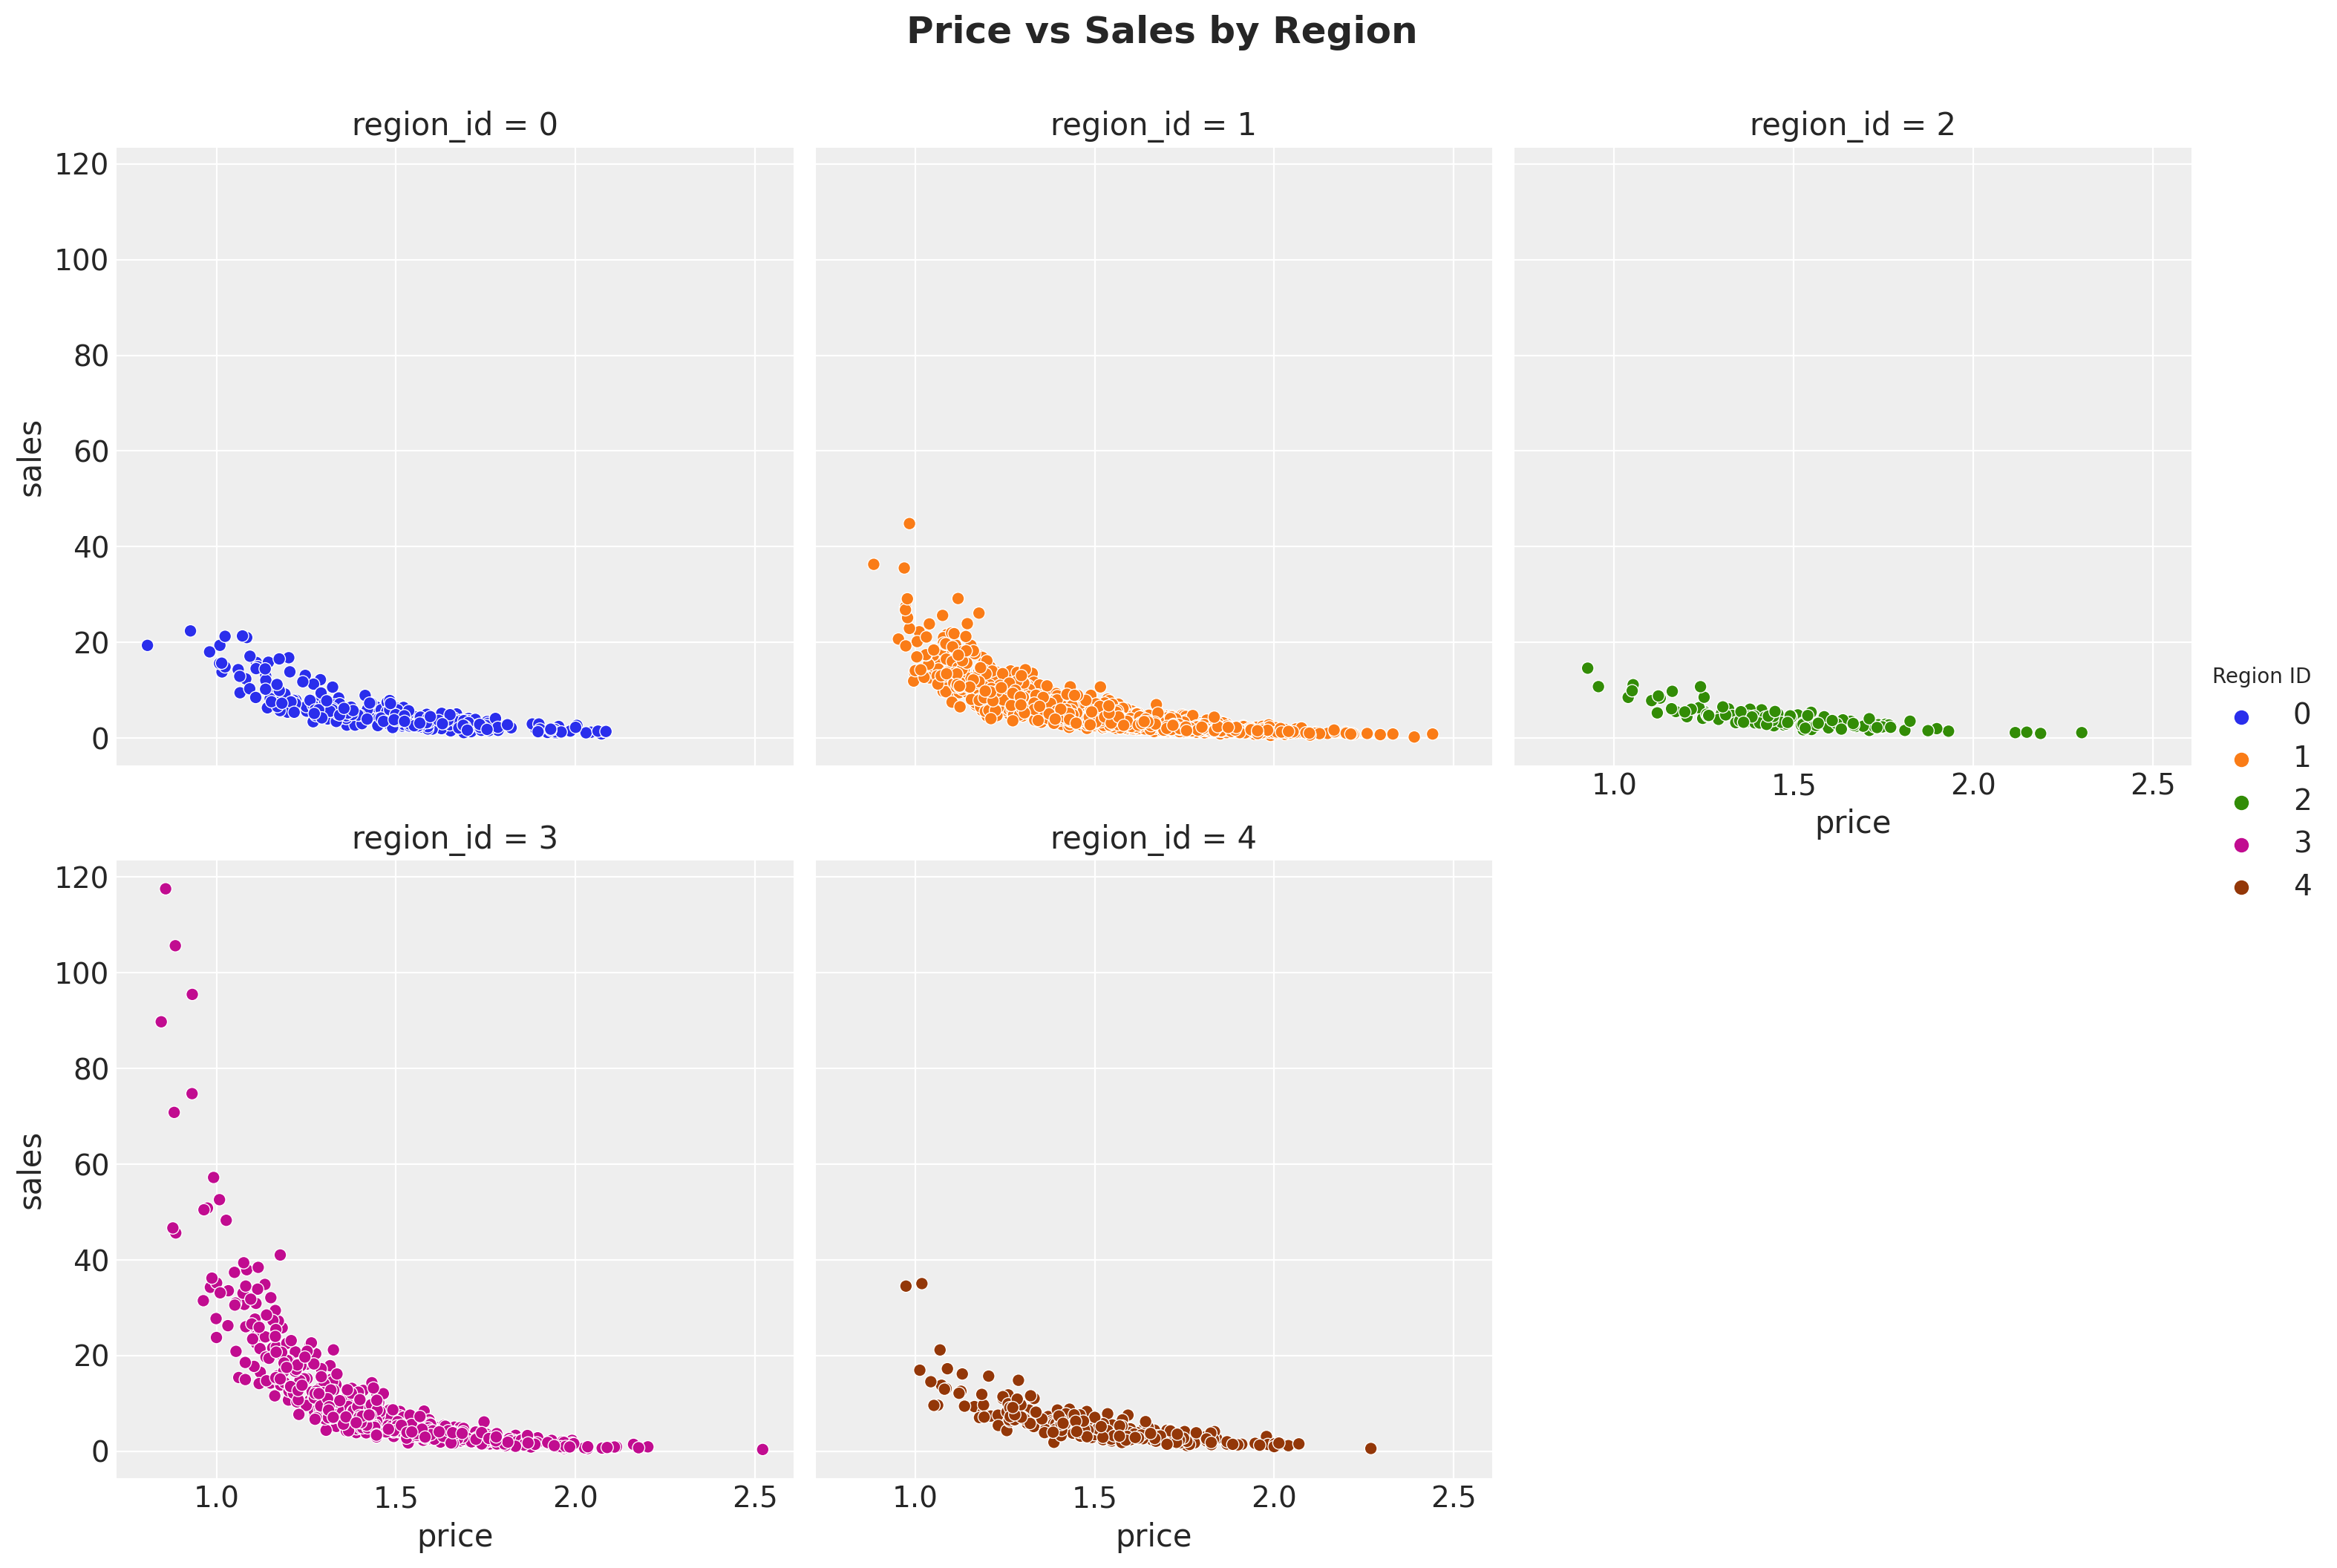

In [9]:
g = sns.relplot(
    data=market_df,
    x="price",
    y="sales",
    kind="scatter",
    col="region_id",
    col_wrap=3,
    hue="region_id",
    facet_kws={"sharex": True, "sharey": True},
)
legend = g.legend
legend.set_title(title="Region ID", prop={"size": 10})
g.fig.suptitle("Price vs Sales by Region", y=1.05, fontsize=18, fontweight="bold")

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'Log Price vs Log Sales by Region')

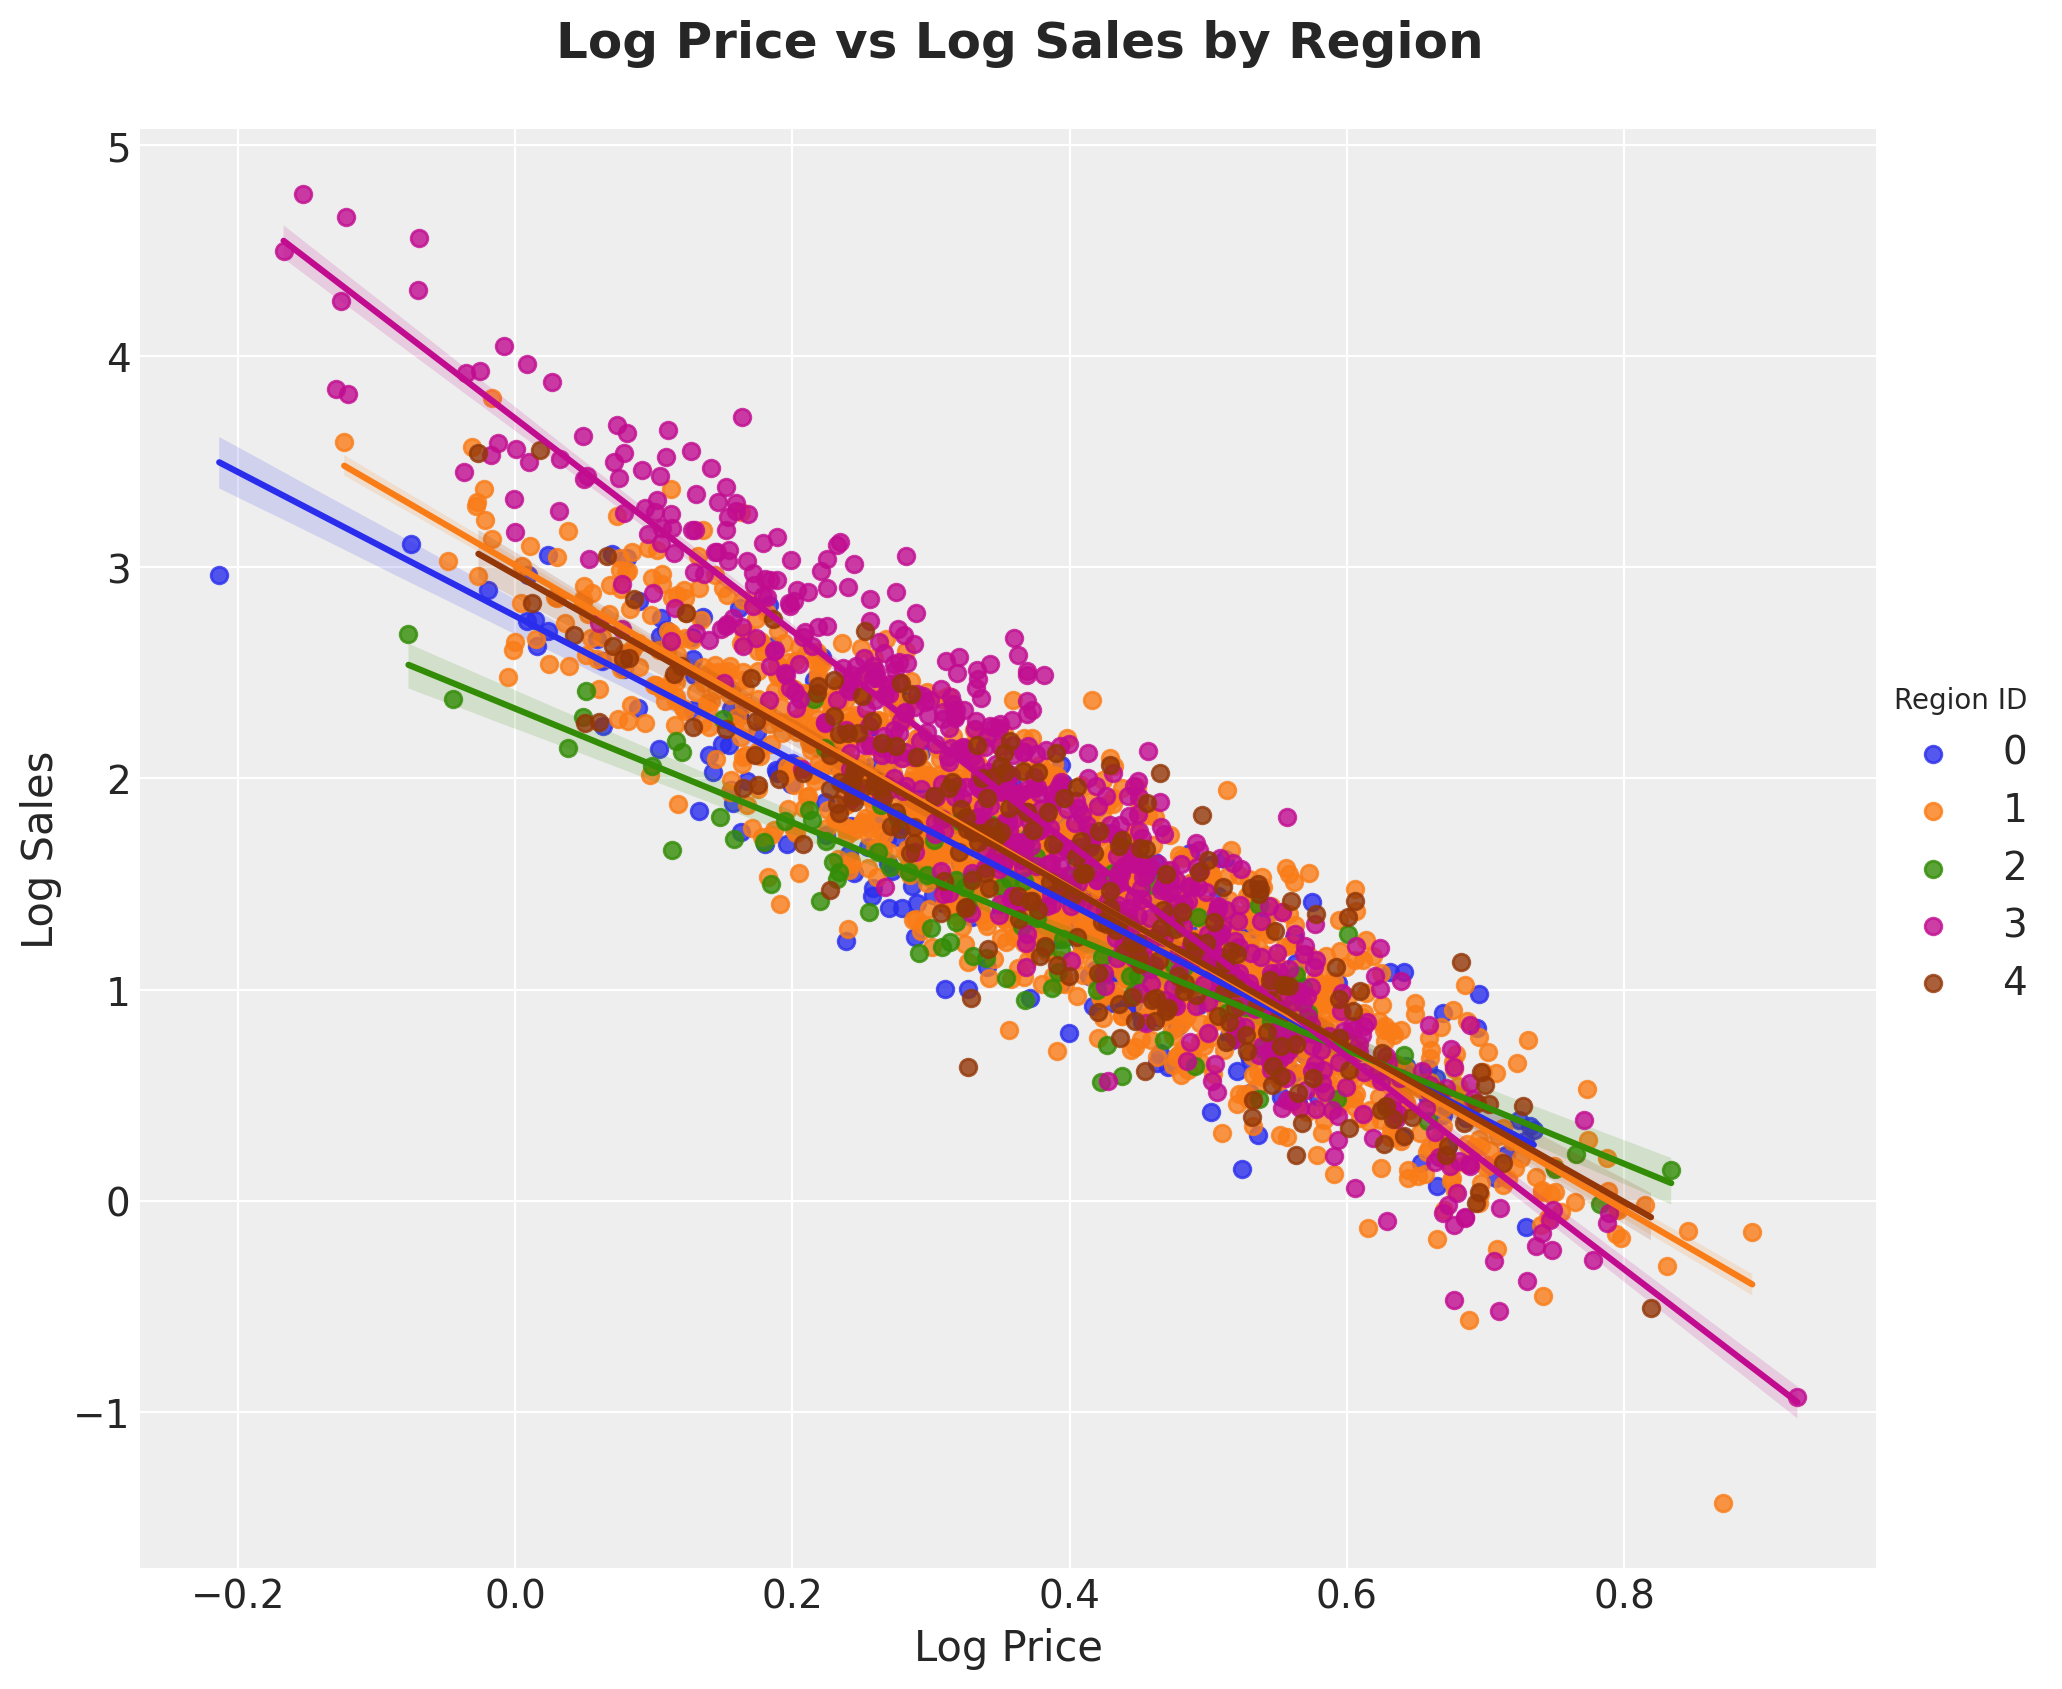

In [10]:
g = sns.lmplot(
    data=market_df, x="log_price", y="log_sales", hue="region_id", height=8, aspect=1.2
)
g.set_axis_labels(x_var="Log Price", y_var="Log Sales")
legend = g.legend
legend.set_title(title="Region ID", prop={"size": 10})
g.fig.suptitle(
    "Log Price vs Log Sales by Region", y=1.05, fontsize=18, fontweight="bold"
)


Text(0.5, 1.0, 'Median Income by Region')

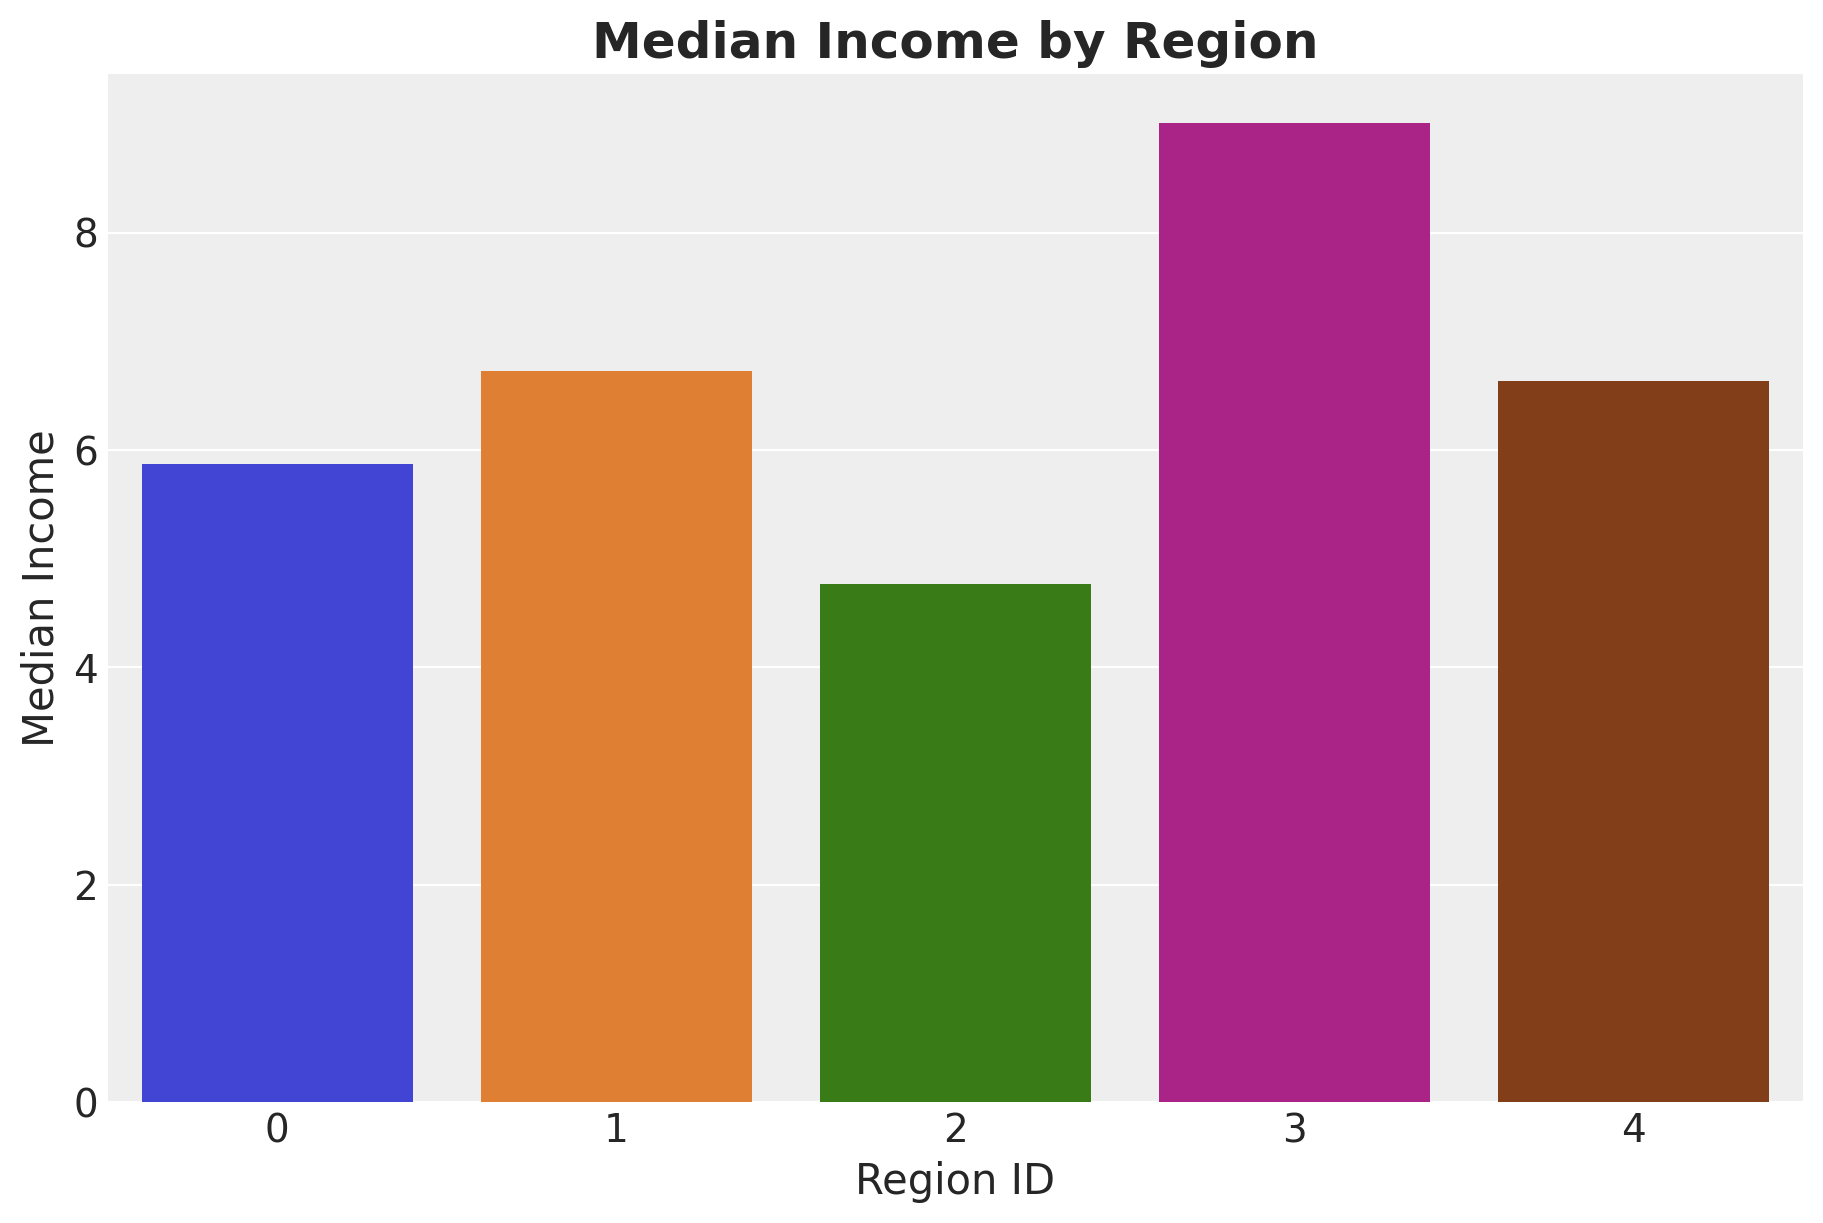

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))
(
    market_df.groupby("region_id", as_index=False)
    .agg({"median_income": np.mean})
    .pipe((sns.barplot, "data"), x="region_id", y="median_income", ax=ax)
)
ax.set(xlabel="Region ID", ylabel="Median Income")
ax.set_title(label="Median Income by Region", fontsize=18, fontweight="bold")

Text(0.5, 1.0, 'Price by Store in Region 2')

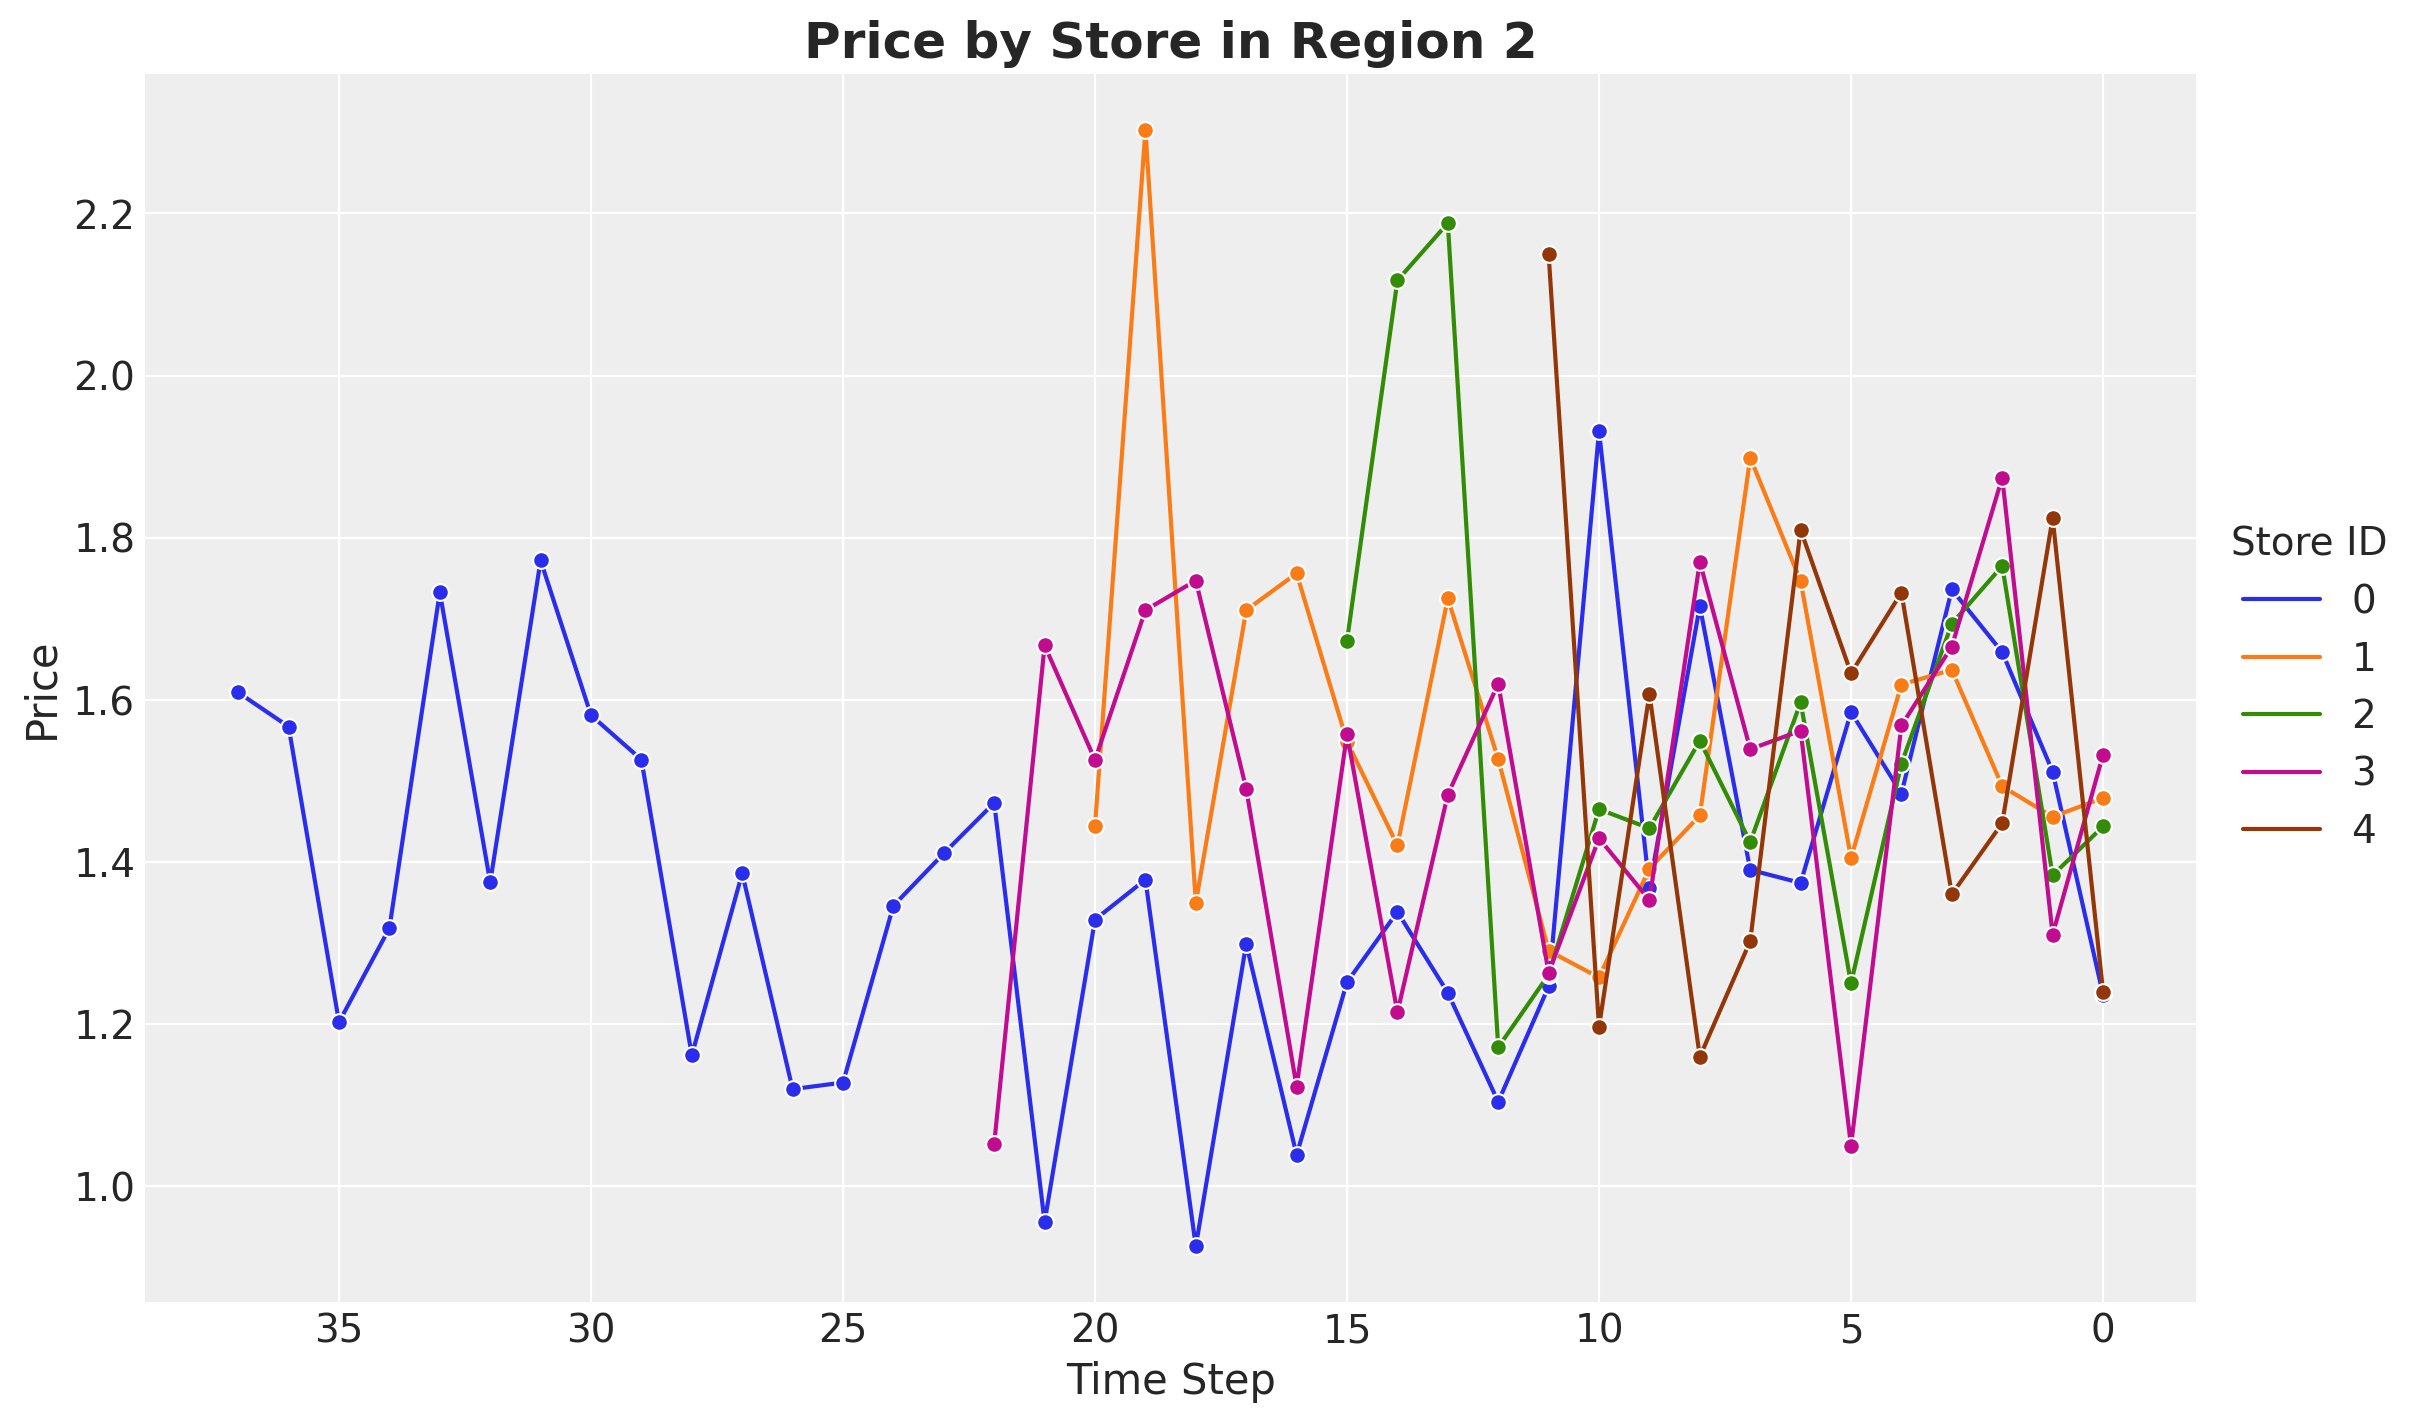

In [12]:
fig, ax = plt.subplots()
sns.lineplot(
    data=market_df.query("region_id == 2").assign(
        store_id=lambda x: x["store_id"].astype("category")
    ),
    x="time_step",
    y="price",
    hue="store_id",
    marker="o",
)
ax.invert_xaxis()
ax.legend(
    title="Store ID", title_fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5)
)
ax.set(xlabel="Time Step", ylabel="Price")
ax.set_title(label="Price by Store in Region 2", fontsize=18, fontweight="bold")


In [13]:
obs = market_df.index.to_numpy()
price = market_df["price"].to_numpy()
log_price = market_df["log_price"].to_numpy()
sales = market_df["sales"].to_numpy()
log_sales = market_df["log_sales"].to_numpy()
median_income_idx, median_income = market_df["median_income"].factorize(sort=True)
store_idx, store = market_df["region_store_id"].factorize(sort=True)
region_idx, region = market_df["region_id"].factorize(sort=True)

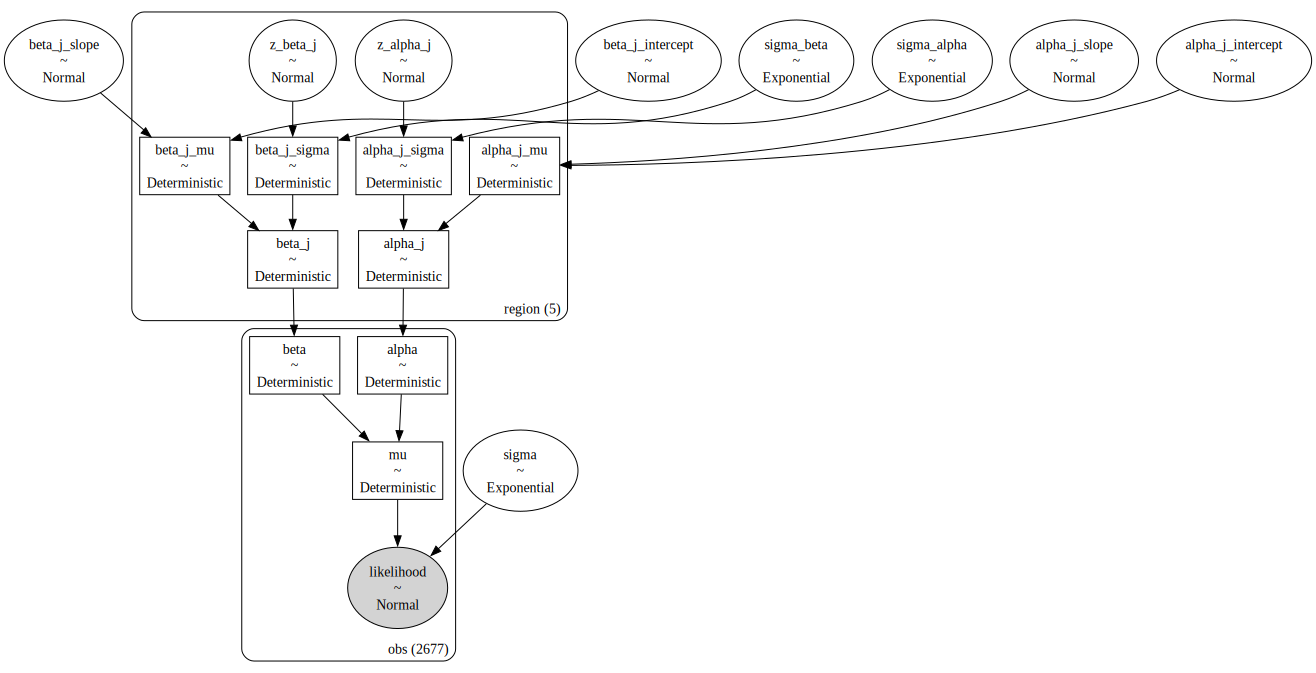

In [14]:
coords = {"store": store, "region": region, "obs": obs}

with pm.Model(coords=coords) as model:
    # --- Priors ---

    alpha_j_intercept = pm.Normal(name="alpha_j_intercept", mu=0, sigma=1)
    alpha_j_slope = pm.Normal(name="alpha_j_slope", mu=0, sigma=1)
    sigma_alpha = pm.Exponential(name="sigma_alpha", lam=1 / 0.1)
    z_alpha_j = pm.Normal(name="z_alpha_j", mu=0, sigma=1, dims="region")

    beta_j_intercept = pm.Normal(name="beta_j_intercept", mu=0, sigma=1)
    beta_j_slope = pm.Normal(name="beta_j_slope", mu=0, sigma=1)
    sigma_beta = pm.Exponential(name="sigma_beta", lam=1 / 0.1)
    z_beta_j = pm.Normal(name="z_beta_j", mu=0, sigma=1, dims="region")

    sigma = pm.Exponential(name="sigma", lam=1 / 0.5)

    # --- Parametrization ---

    alpha_j_mu = pm.Deterministic(
        name="alpha_j_mu",
        var=alpha_j_intercept + alpha_j_slope * median_income.to_numpy(),
        dims="region",
    )
    alpha_j_sigma = pm.Deterministic(
        name="alpha_j_sigma", var=sigma_alpha * z_alpha_j, dims="region"
    )
    alpha_j = pm.Deterministic(
        name="alpha_j",
        var=alpha_j_mu + alpha_j_sigma,
        dims="region",
    )

    beta_j_mu = pm.Deterministic(
        name="beta_j_mu",
        var=beta_j_intercept + beta_j_slope * median_income.to_numpy(),
        dims="region",
    )
    beta_j_sigma = pm.Deterministic(
        name="beta_j_sigma", var=sigma_beta * z_beta_j, dims="region"
    )
    beta_j = pm.Deterministic(
        name="beta_j",
        var=beta_j_mu + beta_j_sigma,
        dims="region",
    )

    alpha = pm.Deterministic(name="alpha", var=alpha_j[region_idx], dims="obs")
    beta = pm.Deterministic(name="beta", var=beta_j[region_idx], dims="obs")

    mu = pm.Deterministic(name="mu", var=alpha + beta * log_price, dims="obs")

    # --- Likelihood ---

    pm.Normal(name="likelihood", mu=mu, sigma=sigma, observed=log_sales, dims="obs")

pm.model_to_graphviz(model=model)

In [15]:
with model:
    idata = pm.sample(
        target_accept=0.95,
        draws=5_000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.534666
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:05:03.747648
Transforming variables...
Transformation time =  0:00:02.080852


Sampling: [likelihood]


In [16]:
idata["sample_stats"]["diverging"].sum().item()


0

In [17]:
var_names = [
    "alpha_j_intercept",
    "alpha_j_slope",
    "beta_j_intercept",
    "beta_j_slope",
    "alpha_j",
    "beta_j",
    "sigma",
]

az.summary(data=idata, var_names=var_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_j_intercept  1.405  0.766  -0.056    2.820      0.008    0.005   
alpha_j_slope      0.228  0.116   0.017    0.449      0.001    0.001   
beta_j_intercept  -1.168  0.870  -2.774    0.502      0.008    0.005   
beta_j_slope      -0.378  0.133  -0.640   -0.141      0.001    0.001   
alpha_j[0]         2.764  0.041   2.690    2.845      0.000    0.000   
alpha_j[1]         3.009  0.020   2.971    3.047      0.000    0.000   
alpha_j[2]         2.370  0.068   2.245    2.499      0.000    0.000   
alpha_j[3]         3.696  0.027   3.646    3.748      0.000    0.000   
alpha_j[4]         2.984  0.051   2.889    3.081      0.000    0.000   
beta_j[0]         -3.394  0.099  -3.577   -3.208      0.001    0.000   
beta_j[1]         -3.813  0.047  -3.899   -3.722      0.000    0.000   
beta_j[2]         -2.790  0.163  -3.101   -2.491      0.001    0.001   
beta_j[3]         -5.015  0.065  -5.137   -4.896      0.000    0.000   
beta_j[4]         -3.758  0.118  -3.977   -3.534      0.001    0.001   
sigma              0.293  0.004   0.286    0.300      0.000    0.000   

                   ess_bulk  ess_tail  r_hat  
alpha_j_intercept   10305.0   12796.0    1.0  
alpha_j_slope       10477.0   12776.0    1.0  
beta_j_intercept    13108.0   15001.0    1.0  
beta_j_slope        13615.0   16213.0    1.0  
alpha_j[0]          26250.0   19458.0    1.0  
alpha_j[1]          25914.0   21791.0    1.0  
alpha_j[2]          25587.0   18201.0    1.0  
alpha_j[3]          24698.0   19922.0    1.0  
alpha_j[4]          26292.0   19436.0    1.0  
beta_j[0]           26163.0   18924.0    1.0  
beta_j[1]           26300.0   22066.0    1.0  
beta_j[2]           26645.0   16841.0    1.0  
beta_j[3]           25186.0   19440.0    1.0  
beta_j[4]           26349.0   19201.0    1.0  
sigma               38197.0   16058.0    1.0

Text(0.5, 0.98, 'Model - Trace')

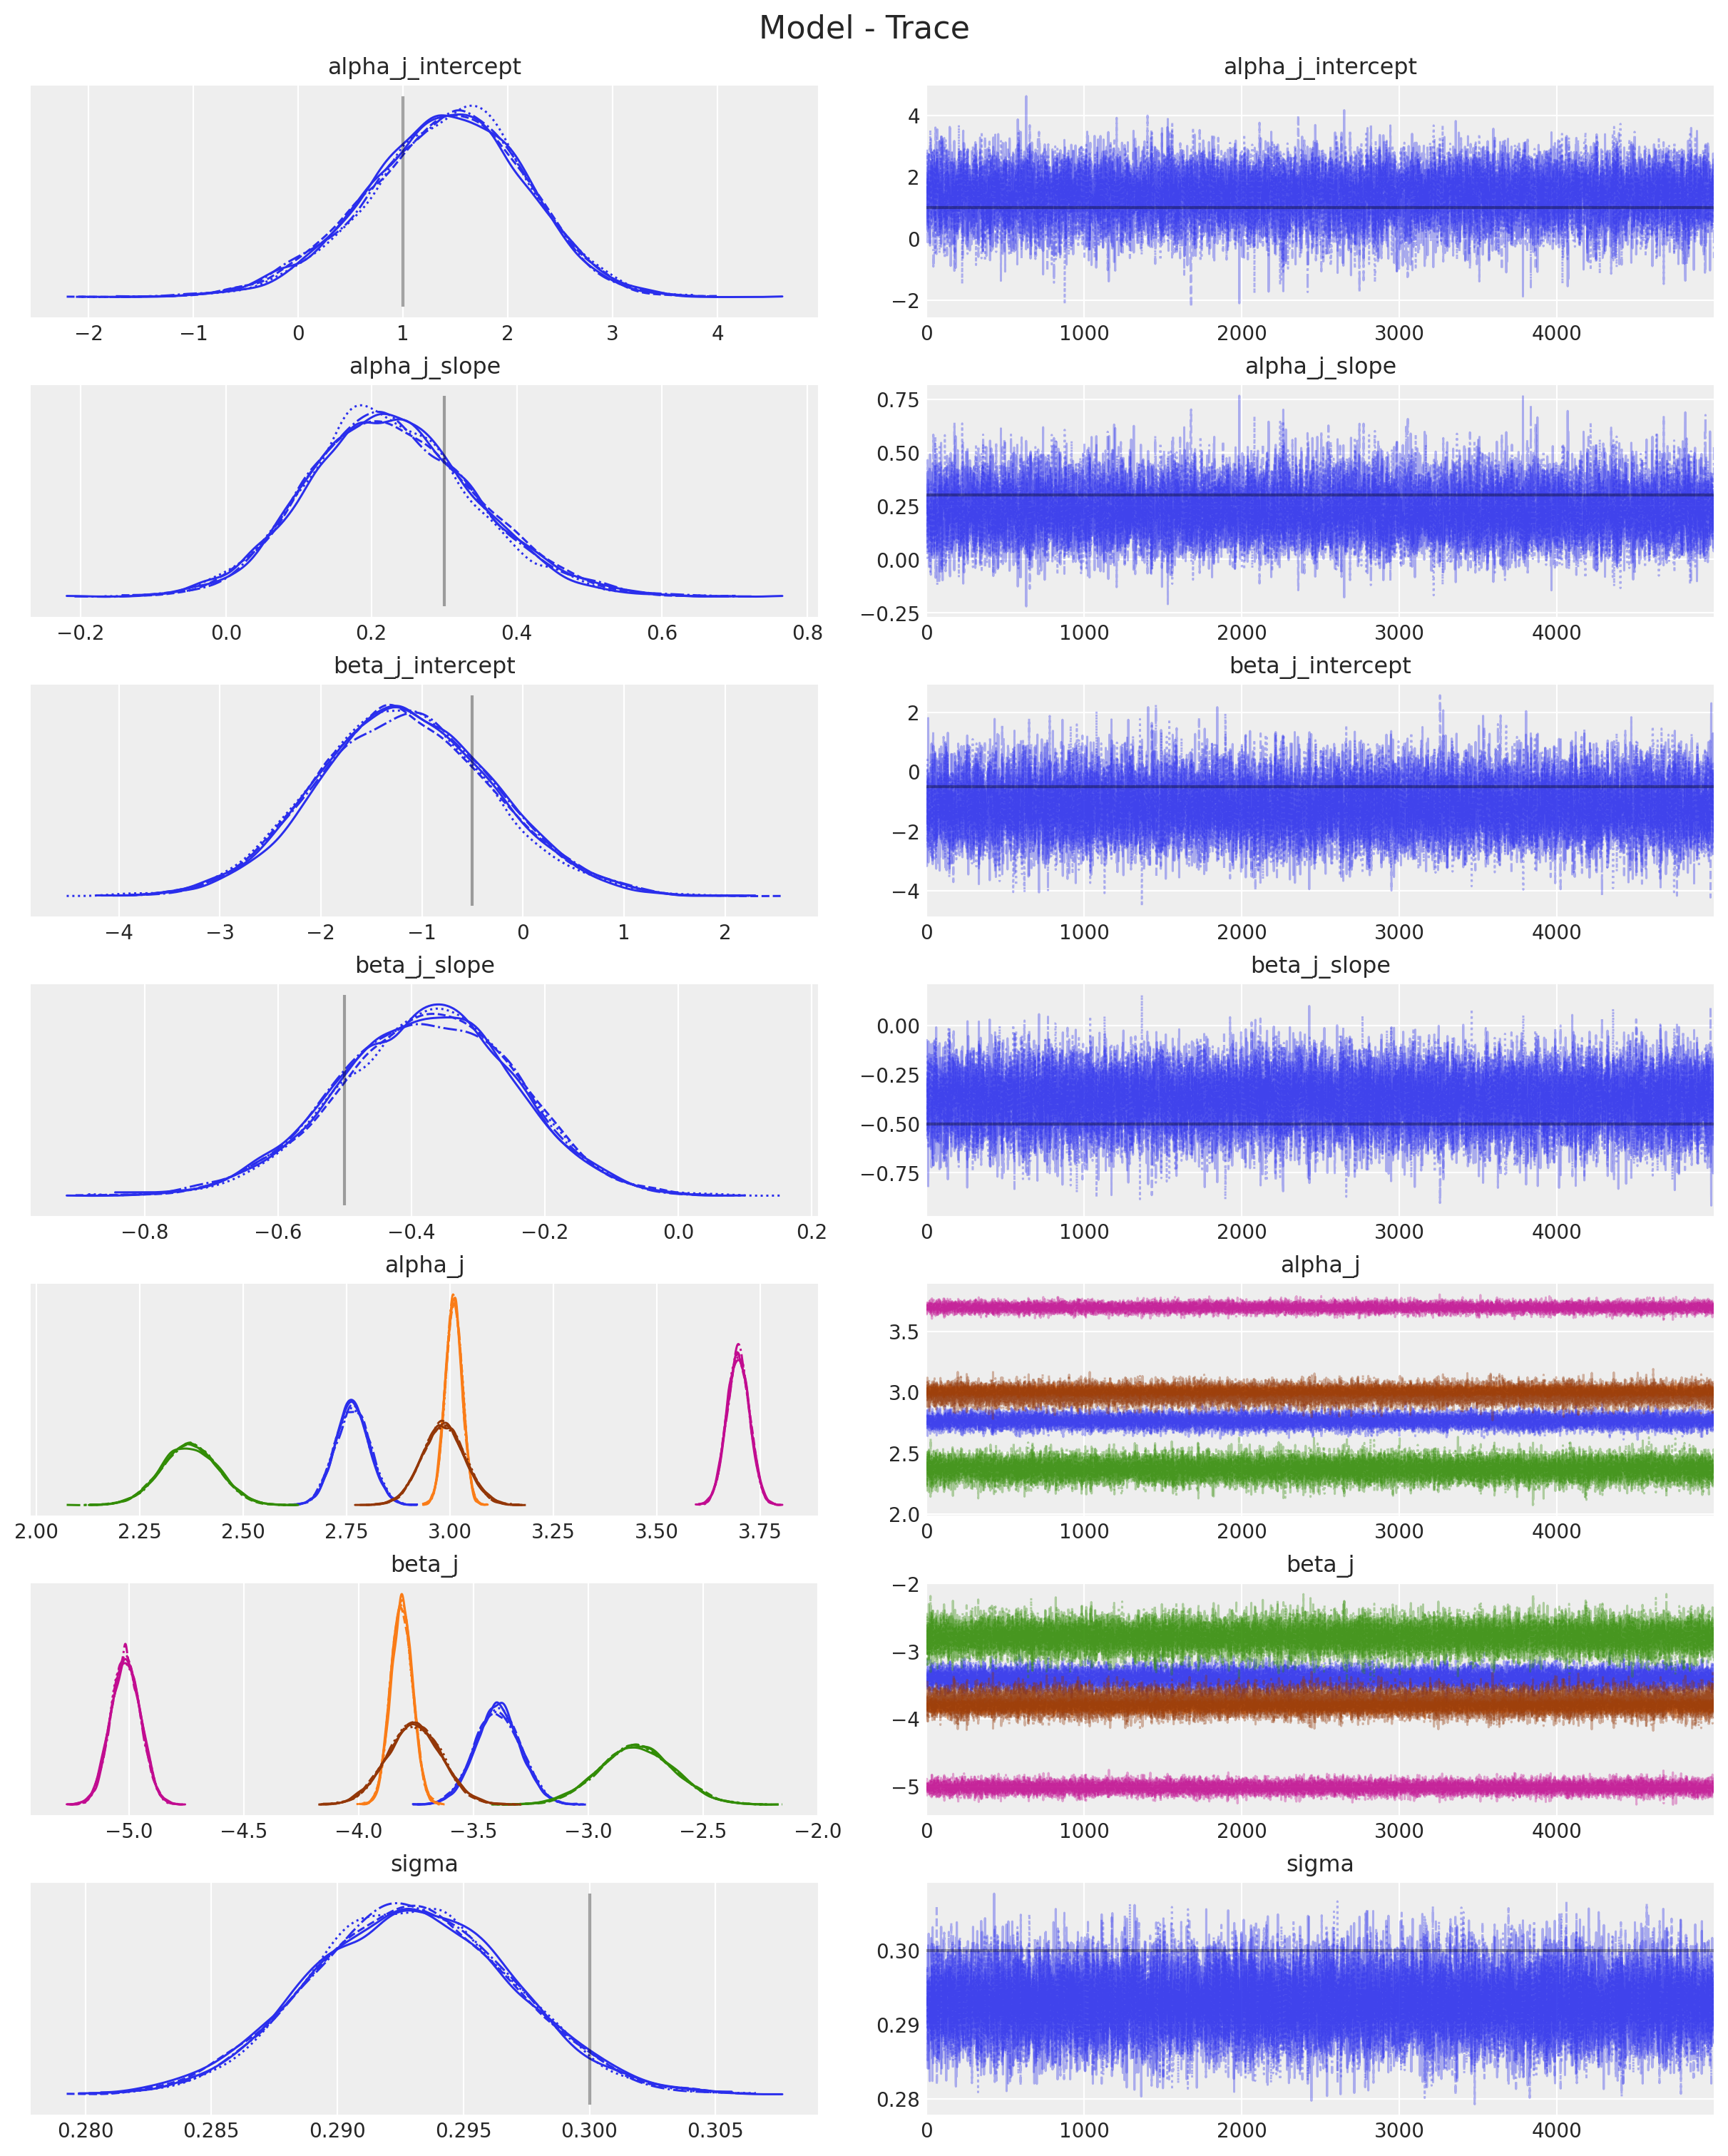

In [18]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    lines=[
        ("alpha_j_intercept", {}, data_generator.intercepts_lr_config.intercept),
        ("alpha_j_slope", {}, data_generator.intercepts_lr_config.slope),
        ("beta_j_intercept", {}, data_generator.slopes_lr_config.intercept),
        ("beta_j_slope", {}, data_generator.slopes_lr_config.slope),
        ("sigma", {}, data_generator.epsilon),
    ],
    compact=True,
    # kind="rank_bars",
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Model - Trace", fontsize=16)

array([[<Axes: ylabel='alpha_j_slope'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta_j_intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha_j_intercept', ylabel='beta_j_slope'>,
        <Axes: xlabel='alpha_j_slope'>,
        <Axes: xlabel='beta_j_intercept'>]], dtype=object)

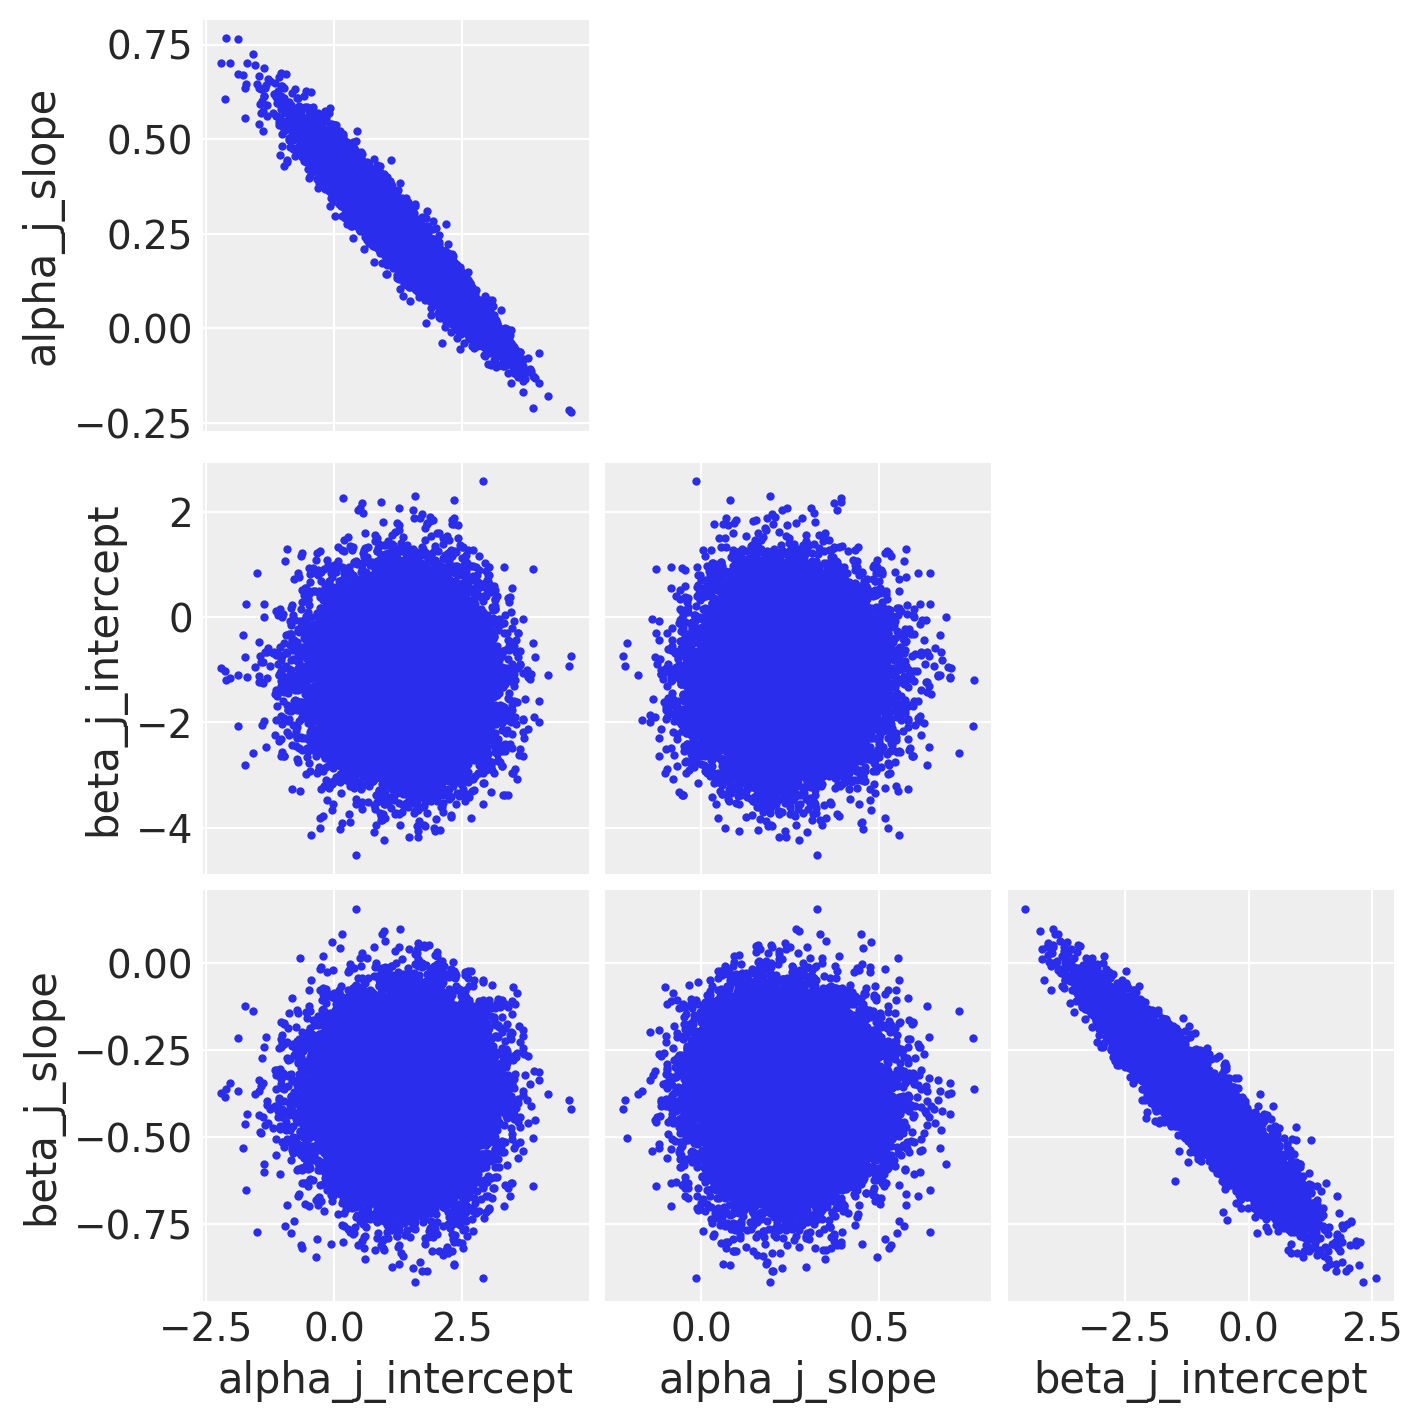

In [19]:
az.plot_pair(
    data=idata,
    var_names=[
        "alpha_j_intercept",
        "alpha_j_slope",
        "beta_j_intercept",
        "beta_j_slope",
    ],
    figsize=(7, 7),
)


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='alpha_j\n1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha_j\n2'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha_j\n3'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha_j\n4'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta_j\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta_j\n1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta_j\n2'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha_j\n0', ylabel='beta_j\n3'>,
        <Axes: xlabel='alpha_j\n1'>, <Axes: xlabel='alpha_j\n2'>,
        <Axes: xlabel='alpha_j\n3'>, <Axes: xlabel='alpha_j\n4'>,
  

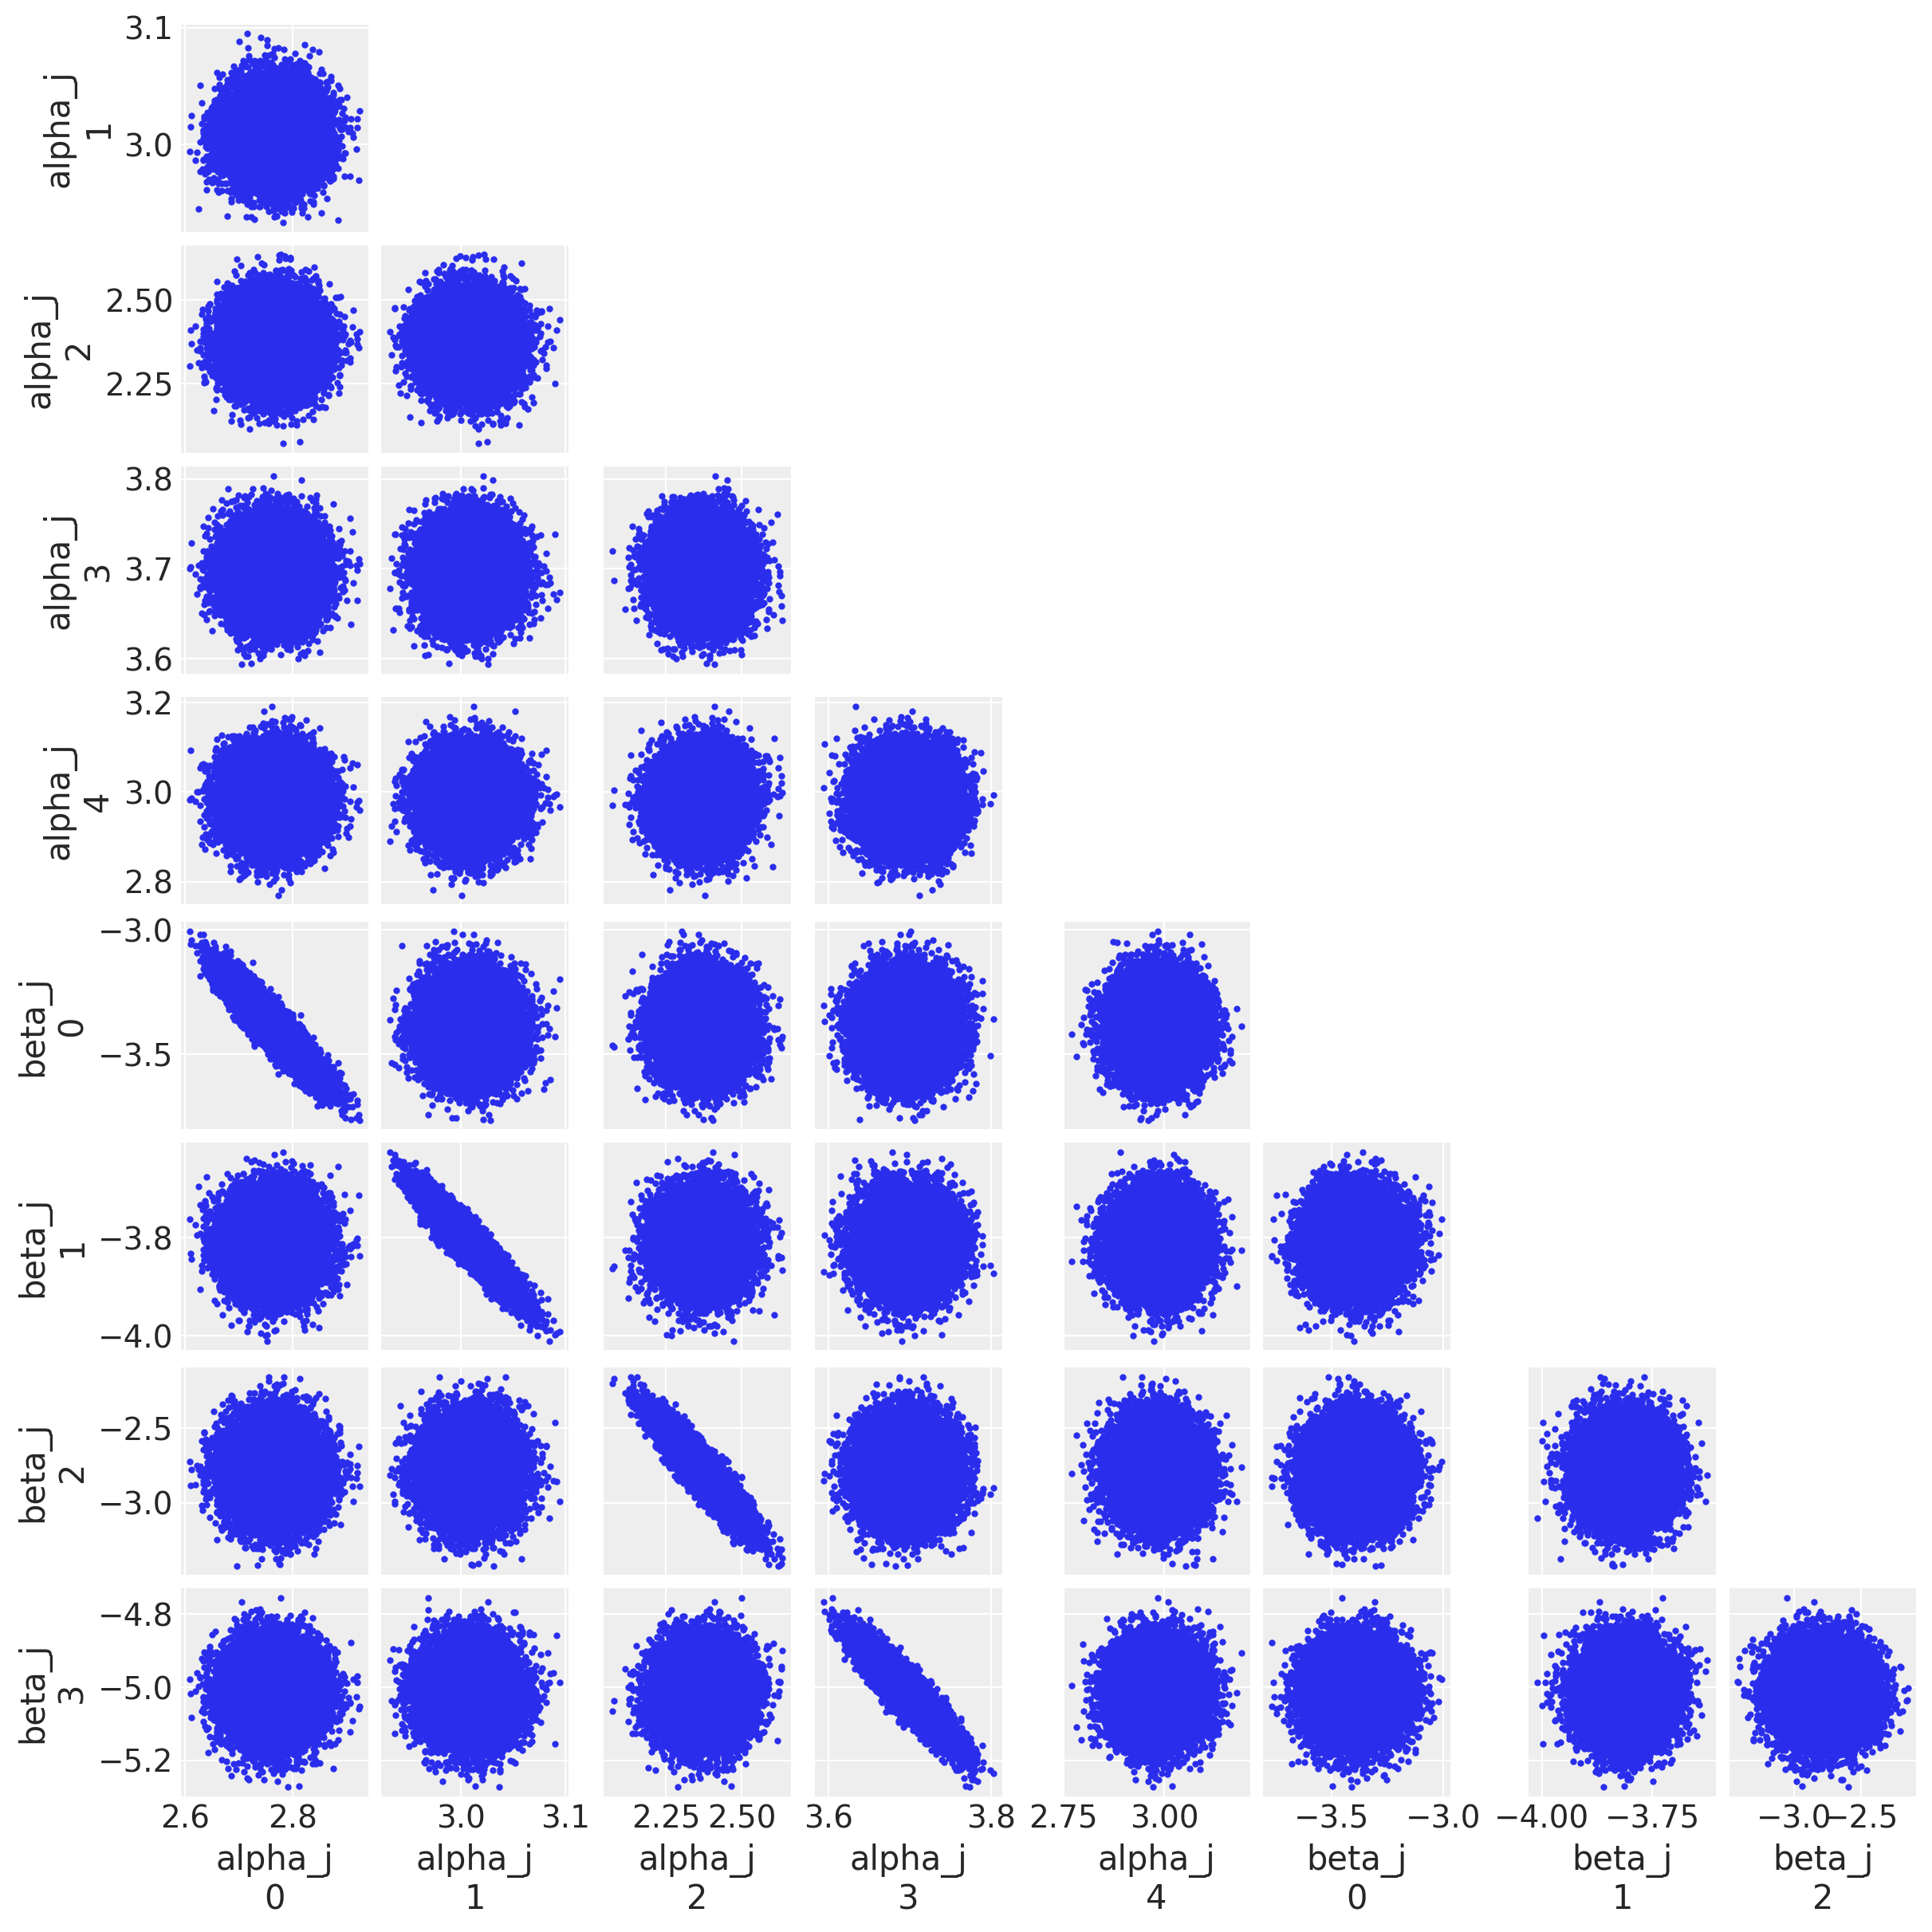

In [20]:
az.plot_pair(
    data=idata,
    var_names=[
        "alpha_j",
        "beta_j",
    ],
    figsize=(12, 12),
)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

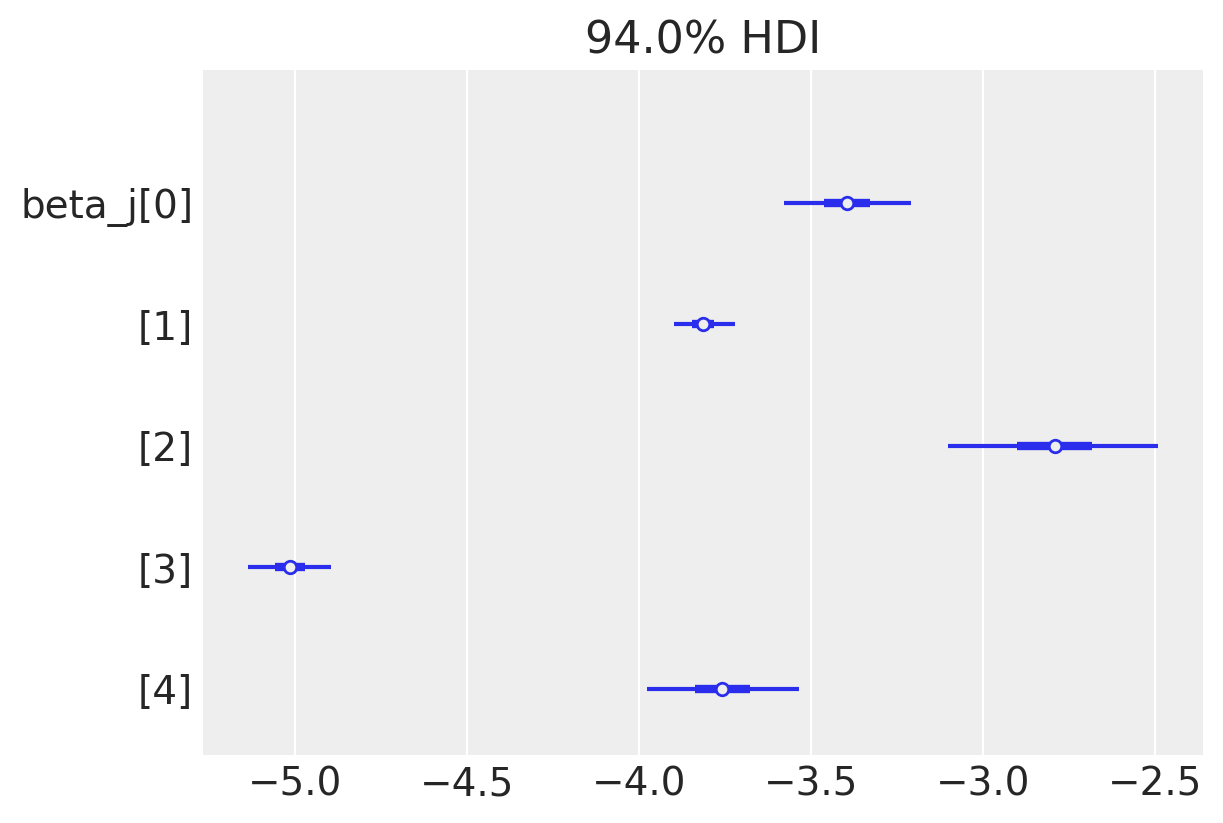

In [26]:
az.plot_forest(
    data=idata,
    var_names=["beta_j"],
    combined=True,
    figsize=(6, 4),
)


In [21]:
# ax = az.plot_ppc(
#     data=posterior_predictive,
#     observed_rug=True,
#     random_seed=seed,
# )
# ax.set(
#     title="Posterior Predictive Check",
#     xlabel="likelihood",
#     # xlim=(-0.5, 1.5),
# )


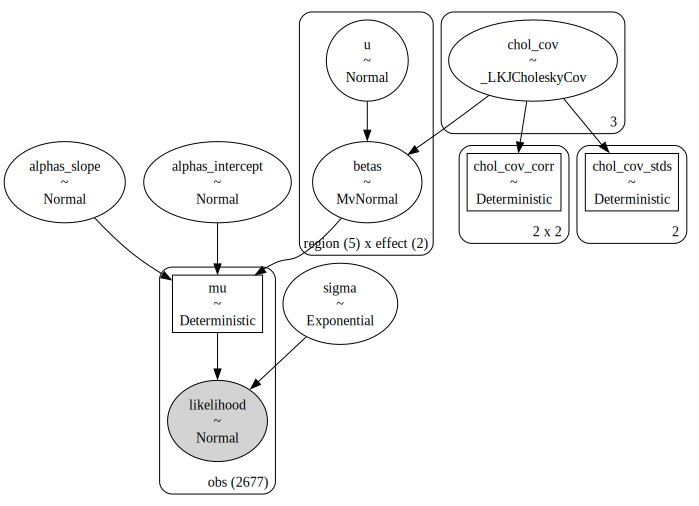

In [28]:
import pytensor.tensor as pt

# https://tomicapretto.github.io/posts/2022-06-12_lkj-prior/#model-3-correlated-priors-with-lkjcorr.

coords = {
    "store": store,
    "region": region,
    "obs": obs,
    "effect": ["intercept", "slope"],
}

with pm.Model(coords=coords) as model_cov:
    # --- Priors ---

    alpha_intercept = pm.Normal(name="alphas_intercept", mu=0, sigma=1)
    alpha_slope = pm.Normal(name="alphas_slope", mu=0, sigma=1)

    sd_dist = pm.HalfCauchy.dist(beta=2, shape=2)
    chol, corr, sigmas = pm.LKJCholeskyCov(name="chol_cov", eta=2, n=2, sd_dist=sd_dist)

    u = pm.Normal(name="u", mu=0, sigma=1, dims=("region", "effect"))

    sigma = pm.Exponential(name="sigma", lam=1 / 0.5)

    # --- Parametrization ---

    betas = pm.MvNormal(
        name="betas",
        mu=u,
        chol=chol,
        dims=("region", "effect"),
    )

    mu = pm.Deterministic(
        name="mu",
        var=(alpha_intercept + betas[region_idx, 0])
        + (alpha_slope + betas[region_idx, 1]) * log_price,
        dims="obs",
    )

    # --- Likelihood ---

    pm.Normal(name="likelihood", mu=mu, sigma=sigma, observed=log_sales, dims="obs")

pm.model_to_graphviz(model=model_cov)

In [29]:
with model_cov:
    idata_cov = pm.sample(
        target_accept=0.95,
        draws=5_000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive_cov = pm.sample_posterior_predictive(
        trace=idata_cov, random_seed=rng
    )


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:06.249385
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:06:56.372261
Transforming variables...


Sampling: [likelihood]


Transformation time =  0:00:06.943928


In [30]:
idata_cov["sample_stats"]["diverging"].sum().item()

15

In [31]:
var_names = [
    # "alpha_j_intercept",
    # "alpha_j_slope",
    # "beta_j_intercept",
    # "beta_j_slope",
    # "alpha",
    "betas",
    "sigma",
]

az.summary(data=idata_cov, var_names=var_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
betas[0, intercept]  0.774  0.762  -0.549    2.248      0.014    0.010   
betas[0, slope]     -1.263  1.018  -3.232    0.363      0.019    0.014   
betas[1, intercept]  1.017  0.761  -0.261    2.540      0.014    0.010   
betas[1, slope]     -1.676  1.015  -3.626   -0.051      0.019    0.014   
betas[2, intercept]  0.337  0.762  -0.970    1.833      0.014    0.010   
betas[2, slope]     -0.554  1.023  -2.485    1.148      0.019    0.014   
betas[3, intercept]  1.710  0.762   0.426    3.225      0.014    0.010   
betas[3, slope]     -2.891  1.018  -4.839   -1.251      0.019    0.014   
betas[4, intercept]  0.968  0.763  -0.316    2.480      0.014    0.010   
betas[4, slope]     -1.565  1.022  -3.487    0.136      0.019    0.014   
sigma                0.293  0.004   0.285    0.301      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
betas[0, intercept]    3218.0    4639.0    1.0  
betas[0, slope]        2856.0    6881.0    1.0  
betas[1, intercept]    3198.0    4516.0    1.0  
betas[1, slope]        2830.0    7310.0    1.0  
betas[2, intercept]    3201.0    4506.0    1.0  
betas[2, slope]        2881.0    7408.0    1.0  
betas[3, intercept]    3195.0    4503.0    1.0  
betas[3, slope]        2829.0    6920.0    1.0  
betas[4, intercept]    3217.0    4456.0    1.0  
betas[4, slope]        2868.0    7142.0    1.0  
sigma                 24072.0   16386.0    1.0

Text(0.5, 0.98, 'Model - Trace')

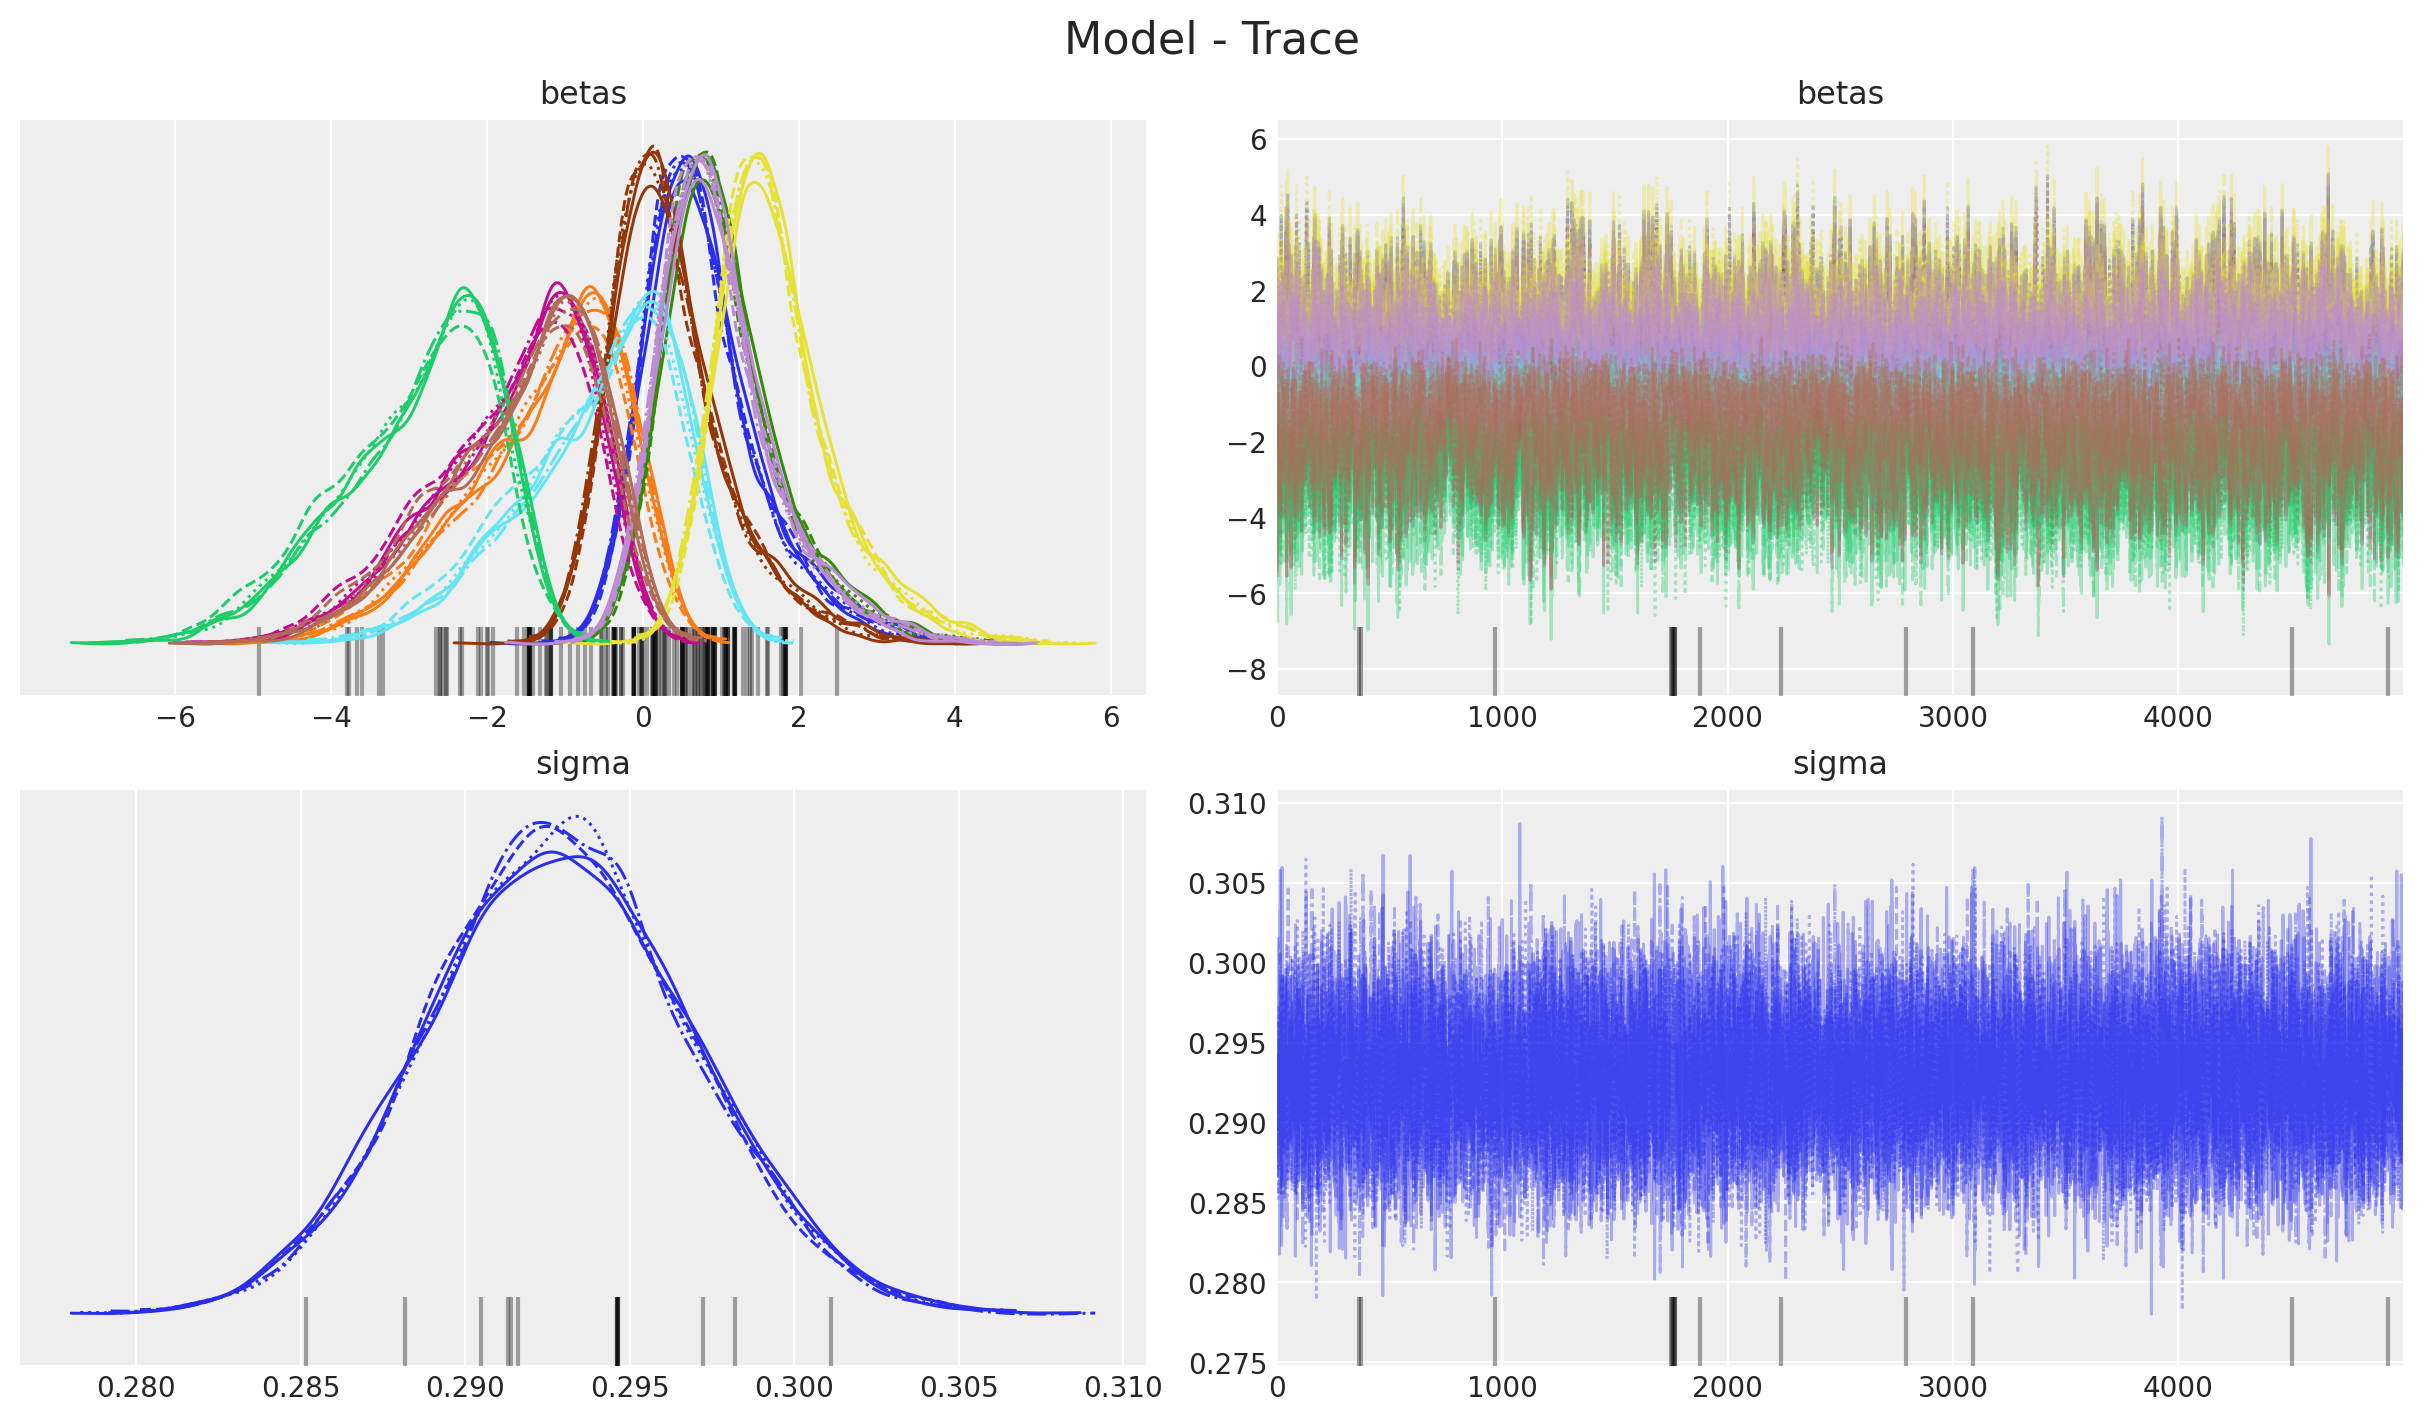

In [32]:
axes = az.plot_trace(
    data=idata_cov,
    var_names=var_names,
    # lines=[
    #     ("alpha_j_intercept", {}, data_generator.intercepts_lr_config.intercept),
    #     ("alpha_j_slope", {}, data_generator.intercepts_lr_config.slope),
    #     ("beta_j_intercept", {}, data_generator.slopes_lr_config.intercept),
    #     ("beta_j_slope", {}, data_generator.slopes_lr_config.slope),
    #     ("sigma", {}, data_generator.epsilon),
    # ],
    compact=True,
    # kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Model - Trace", fontsize=16)
